ส่วนที่ 1: การนำเข้า Libraries และโหลดข้อมูล

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
warnings.filterwarnings('ignore')

# Load and inspect the dataset
file_path = 'data/xauusd.csv'
xausd_data = pd.read_csv(file_path)
xausd_data['time'] = pd.to_datetime(xausd_data['time'], dayfirst=True)

# Display dataset info and the first few rows
xausd_data.info()
xausd_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415975 entries, 0 to 415974
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    415975 non-null  datetime64[ns]
 1   open    415975 non-null  float64       
 2   high    415975 non-null  float64       
 3   low     415975 non-null  float64       
 4   close   415975 non-null  float64       
 5   rsi14   415975 non-null  float64       
 6   sma14   415975 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 22.2 MB


,time,open,high,low,close,rsi14,sma14
0,2018-01-01 18:00:00,1302.34,1303.24,1302.34,1302.94,50.02,1302.70
1,2018-01-01 18:05:00,1302.94,1303.17,1302.71,1303.04,51.39,1302.69
2,2018-01-01 18:10:00,1303.03,1303.73,1302.93,1303.73,59.61,1302.73
3,2018-01-01 18:15:00,1303.72,1304.10,1303.58,1303.70,59.14,1302.77
4,2018-01-01 18:20:00,1303.71,1304.82,1303.71,1304.78,68.68,1302.88


ส่วนที่ 2: การสร้างฟีเจอร์จากข้อมูล (Feature Engineering)

In [2]:
# Feature Engineering - Creating Lagged Features
xausd_data['rsi14_lag1'] = xausd_data['rsi14'].shift(1)  # Lag feature for RSI
xausd_data['sma14_lag1'] = xausd_data['sma14'].shift(1)  # Lag feature for SMA

# Drop NaN values that result from shifting
xausd_data.dropna(inplace=True)

# Splitting the dataset into features and target
X = xausd_data[['open', 'high', 'low','rsi14_lag1', 'sma14_lag1']]
y = xausd_data['close']  # Target is the closing price



ส่วนที่ 3: การปรับแต่งข้อมูลด้วย MinMaxScaler และการแบ่งข้อมูล

In [3]:
# สเกลข้อมูลฟีเจอร์ (X) และเป้าหมาย (y)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# แบ่งข้อมูลเป็น training และ testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)


ส่วนที่ 3: Reshape ข้อมูลสำหรับ LSTM

In [4]:
# Reshape the data for LSTM (LSTM requires 3D input: [samples, timesteps, features])
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # แทนที่จะใช้ (1, features), ให้ใช้ (features, 1)
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Reshaped X_train:", X_train_reshaped.shape)
print("Reshaped X_test:", X_test_reshaped.shape)

Reshaped X_train: (332779, 5, 1)
Reshaped X_test: (83195, 5, 1)


ส่วนที่ 4: การสร้างโมเดล และฝึกโมเดล

In [5]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32)

Epoch 1/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 0.0033
Epoch 2/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - loss: 4.6697e-04
Epoch 3/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - loss: 4.2816e-04
Epoch 4/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 136s 8ms/step - loss: 4.0963e-04
Epoch 5/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - loss: 4.0148e-04
Epoch 6/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 3.9353e-04
Epoch 7/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 3.9246e-04
Epoch 8/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - loss: 3.8829e-04
Epoch 9/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 83s 8ms/step - loss: 3.8185e-04
Epoch 10/10
10400/10400 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - loss: 3.8294e-04


ส่วนที่ 5: การทำนายและการคำนวณค่า MSE และ RMSE

In [6]:
# Predict on the test data
y_pred = model.predict(X_test_reshaped)

# Inverse scale the predictions and the true values to their original scale
y_pred_inverse = scaler_y.inverse_transform(y_pred)  # inverse สำหรับ y_pred เท่านั้น
y_test_inverse = scaler_y.inverse_transform(y_test)  # inverse สำหรับ y_test ด้วย

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inverse, y_pred_inverse)
print(f'MSE: {mse}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

2600/2600 ━━━━━━━━━━━━━━━━━━━━ 3s 983us/step
MSE: 28.15092383163469
RMSE: 5.305744418235267


ส่วนที่ 6: การแสดงผลกราฟของการทำนาย

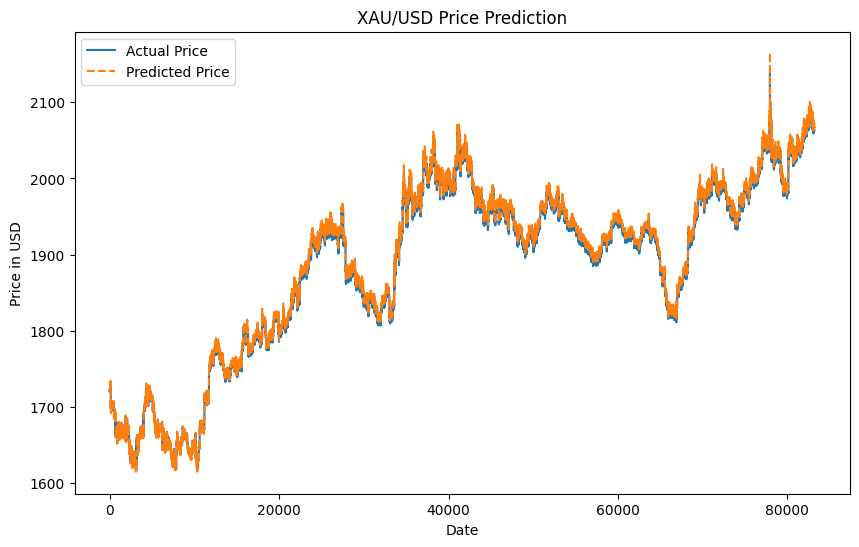

In [7]:
# Visualize the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse, label='Actual Price')
plt.plot(y_pred_inverse, label='Predicted Price', linestyle='--')
plt.title('XAU/USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.show()

ส่วนที่ 7: การทำ Hyperparameter Tuning

In [22]:
# ฟังก์ชันสร้างโมเดล
def create_model(units=50, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))  # กำหนด input_shape ที่นี่
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    
    # Compile โมเดล
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# สร้าง KerasRegressor สำหรับการทำงานร่วมกับ GridSearchCV
model = KerasRegressor(model=create_model, epochs=10, batch_size=32, verbose=0)

# กำหนดพารามิเตอร์สำหรับการทำ Grid Search
param_grid = {
    'model__units': [50, 100],
    'model__dropout_rate': [0.2, 0.3],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

# ใช้ GridSearchCV เพื่อหาพารามิเตอร์ที่ดีที่สุด
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_result = grid.fit(X_train_reshaped, y_train)

# แสดงผลพารามิเตอร์ที่ดีที่สุด
print(f"Best parameters found: {grid_result.best_params_}")
print(f"Best score: {grid_result.best_score_}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits


In [ ]:
# ใช้โมเดลที่ดีที่สุด
best_model = grid_result.best_estimator_

# ทำนายค่าโดยใช้โมเดลที่ดีที่สุด
y_pred = best_model.predict(X_test_reshaped)

# Inverse transform และคำนวณ RMSE
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))  # ปรับขนาด y_test

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
print(f'RMSE: {rmse}')

ส่วนที่ 8: อัพโหลดโมเดล

In [8]:
import pickle

# บันทึกโมเดลลงไฟล์ .pkl
with open("scaler_y.pkl", "wb") as f:
    pickle.dump(scaler_y, f)

In [9]:
from tensorflow.keras.models import load_model

# บันทึกโมเดลหลังจากการฝึกเสร็จสิ้น
model.save('model.h5')  # บันทึกโมเดลเป็นไฟล์ HDF5

In [12]:
from tensorflow.keras.models import load_model

# โหลดโมเดลจากไฟล์ HDF5
model = load_model('model.h5')